#Problem Description

Histopathologic Cancer Detection

This is a binary image classification task aimed at identifying the presence or absence of metastatic cancer in small image patches extracted from larger digital pathology scans.

The objective of this project is to predict the labels for these images. A positive label indicates that the central 32x32 pixel region of a patch contains at least one pixel of tumor tissue.

In [ ]:
#import libraries
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score
import time
import copy
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
#setting environment and parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30 #30
batch_size = 256 #32 #256
num_classes = 2
learning_rate = 0.01

In [ ]:
# to load data
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dir_main = '/content/drive/MyDrive/CuBoulder/DTSA5511DeepLearning/wk3/CancerData'
path = dir_main + '/train/'
annotation_file = dir_main + '/train_labels.csv'
test_path=dir_main + '/test/'

num_train_files = len(os.listdir(path))
num_test_files = len(os.listdir(test_path))

train = pd.read_csv(annotation_file)
sub = pd.read_csv(dir_main + '/sample_submission.csv')

Mounted at /content/drive


# Dataset Description

This dataset contains a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder.

There are two folders where small pathology images are contained.  There are
220025 tif files in the train folder and 57458 tif files in the test folder respectively.  The total size of the both folders combined is about 7.76GB.




# Explortary Data Analysis

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

### show some cancer images from both folders

The first 5 images of train images and test images are shown below.  

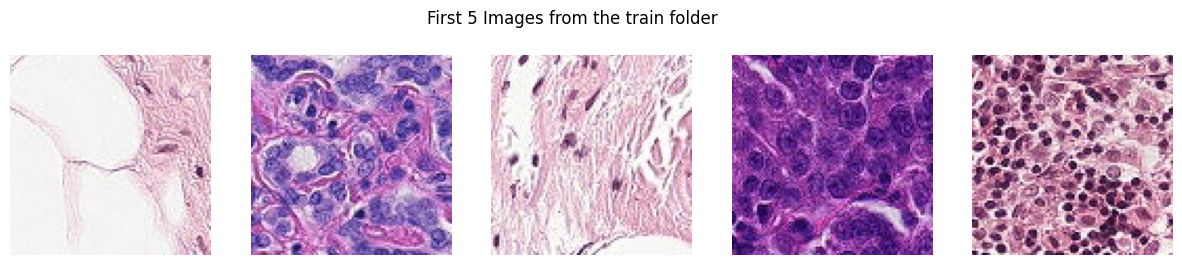

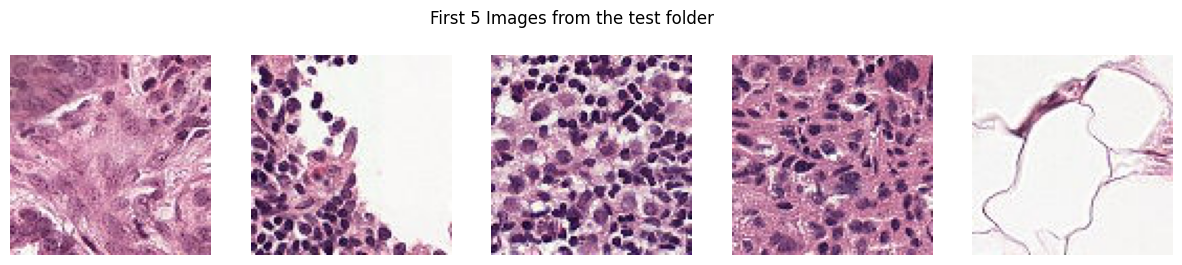

In [ ]:
# show the first 5 images in the train folder
train_files = os.listdir(path)
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image_path = os.path.join(path, train_files[i])
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].axis('off')

plt.suptitle('First 5 Images from the train folder')
plt.show()

# show the first 5 images in the test folder
train_files = os.listdir(test_path)
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image_path = os.path.join(test_path, train_files[i])
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].axis('off')

plt.suptitle('First 5 Images from the test folder')
plt.show()

### check on the image file size.

I checked the size of the cancer images to see if there is anything to learn from it. Based on the bar chart below, all training images have the same size of 86 KB, while all test images have a size of 27 KB.

I was surprised to find that the training images differ in size from the testing images. It is unclear why they are different. It may be important to keep this in mind to determine if there is a need to treat the testing images differently.

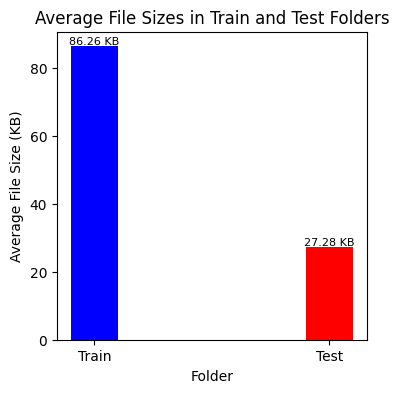

In [ ]:
import matplotlib.pyplot as plt
import os

# Calculate file sizes for each folder
train_files = os.listdir(path)
train_sizes = [os.path.getsize(os.path.join(path, f)) / 1024 for f in train_files]

test_files = os.listdir(test_path)
test_sizes = [os.path.getsize(os.path.join(test_path, f)) / 1024 for f in test_files]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(4,4))

# Calculate the average file sizes
avg_train_size = sum(train_sizes) / len(train_sizes)
avg_test_size = sum(test_sizes) / len(test_sizes)

# Plot the average file sizes as a bar chart
train_bar = ax.bar(['Train'], [avg_train_size], width=0.2, color='b')
test_bar = ax.bar(['Test'], [avg_test_size], width=0.2, color='r')

# Add the average file size value on each bar
ax.text(0, avg_train_size, f"{avg_train_size:.2f} KB", ha='center', va='bottom', fontsize=8)
ax.text(1, avg_test_size, f"{avg_test_size:.2f} KB", ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel("Folder")
ax.set_ylabel("Average File Size (KB)")
ax.set_title("Average File Sizes in Train and Test Folders")

# Show the plot
plt.show()


### Analyzing the pixel value of the images

The following charts show the distribution of pixel values for the images in both the train and test folders. The mean pixel value is 159.91 for train images and 162.34 for test images. All the images tend to be light in color, generally having a light-colored background.

Train Folder:
Mean: 164.44
Median: 175.00
Standard Deviation: 65.98


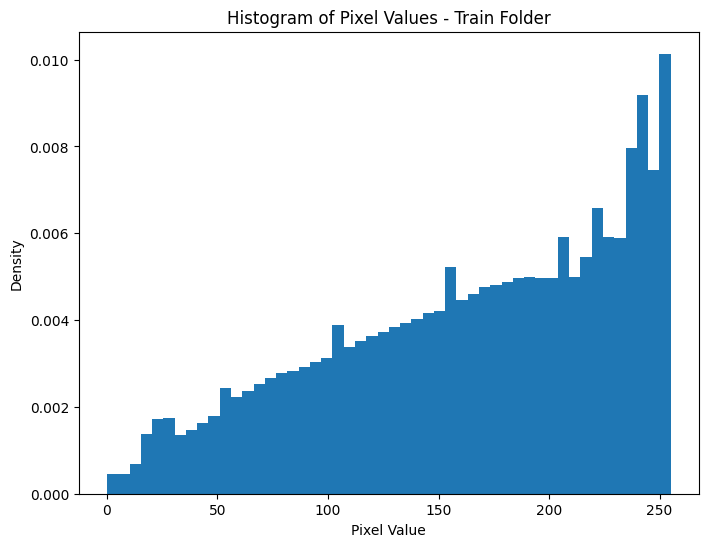


Test Folder:
Mean: 168.94
Median: 180.00
Standard Deviation: 65.27


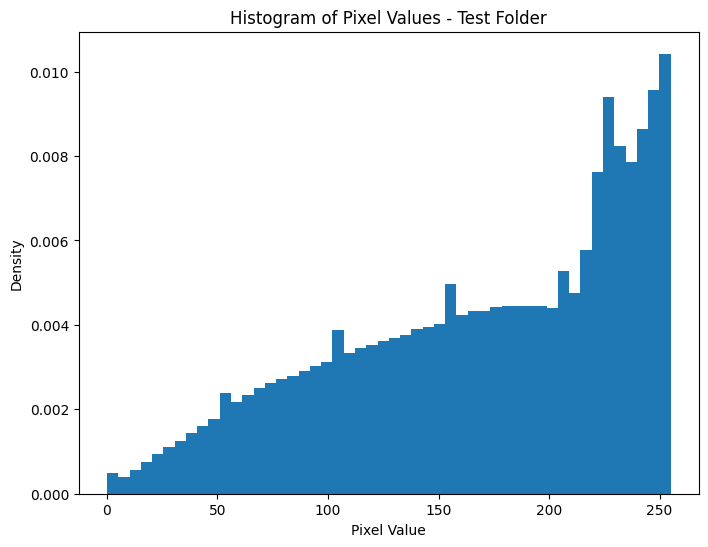

In [ ]:
# Pixel Value Distribution: Compute summary statistics (mean, median, standard deviation) of pixel values.

import os
import numpy as np
from PIL import Image

#dir_main = '/content/drive/MyDrive/CU Boulder/DTSA5511DeepLearning/wk3/CancerData'
#train = os.path.join(dir_main, 'train')
#test_path = os.path.join(dir_main, 'test')

def compute_pixel_stats(folder_path, num_files=100):
    all_pixel_values = []
    tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    # Randomly select 1,000 files
    selected_files = random.sample(tif_files, min(num_files, len(tif_files)))

    for filename in selected_files:
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        pixel_values = np.array(image).flatten()
        all_pixel_values.extend(pixel_values)

    pixel_mean = np.mean(all_pixel_values)
    pixel_median = np.median(all_pixel_values)
    pixel_std = np.std(all_pixel_values)

    return all_pixel_values, pixel_mean, pixel_median, pixel_std

# Compute statistics and plot histogram for the train folder
train_pixel_values, train_mean, train_median, train_std = compute_pixel_stats(path)
print("Train Folder:")
print(f"Mean: {train_mean:.2f}")
print(f"Median: {train_median:.2f}")
print(f"Standard Deviation: {train_std:.2f}")

plt.figure(figsize=(8, 6))
plt.hist(train_pixel_values, bins=50, density=True)
plt.title('Histogram of Pixel Values - Train Folder')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.show()

# Compute statistics and plot histogram for the test folder
test_pixel_values, test_mean, test_median, test_std = compute_pixel_stats(test_path)
print("\nTest Folder:")
print(f"Mean: {test_mean:.2f}")
print(f"Median: {test_median:.2f}")
print(f"Standard Deviation: {test_std:.2f}")

plt.figure(figsize=(8, 6))
plt.hist(test_pixel_values, bins=50, density=True)
plt.title('Histogram of Pixel Values - Test Folder')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.show()

### Reducing training and testing data size

The original dataset is quite large, with over 200,000 training images, which likely exceeds the capacity of the available infrastructure. Therefore, I have reduced the dataset to 4,000 training images and 5,000 testing images.

Since the CSV file contains labels for images that are not part of the selected subset, the following code identifies the labels from the CSV file for the images chosen for training and testing.

In [ ]:
# divide train data into train set and validation set

train_set, val_set = train_test_split(train, stratify=train['label'], test_size=0.05)
print(len(train_set), len(val_set))

# match dataframe of train_set and val_set based on actual files existed in folder

# check train set if files do exist or not
existing_count = 0
missing_count = 0
existing_index = []
for i, v in enumerate(train_set.itertuples(index=True)):
  image_path = os.path.join(path, v.id + '.tif')
  if os.path.exists(image_path):
    existing_count += 1
    existing_index.append(v.Index)
    #print(f"Image {image_path} exists.")
  else:
    missing_count += 1
    #print(f"Image {image_path} does not exist.")
print(f"Number of existing images: {existing_count}")
print(f"Number of missing images: {missing_count}")
train_set = train_set.loc[existing_index]  # update train_set_sample with only the ones that their files exist

# check val set if files do exist or not
existing_count = 0
missing_count = 0
existing_index = []
for i, v in enumerate(val_set.itertuples(index=True)):
  image_path = os.path.join(path, v.id + '.tif')
  if os.path.exists(image_path):
    existing_count += 1
    existing_index.append(v.Index)
    #print(f"Image {image_path} exists.")
  else:
    missing_count += 1
    #print(f"Image {image_path} does not exist.")
print(f"Number of existing images: {existing_count}")
print(f"Number of missing images: {missing_count}")
val_set = val_set.loc[existing_index]  # update train_set_sample with only the ones that their files exist

# check test set if files do exist or not
existing_count = 0
missing_count = 0
existing_index = []
for i, v in enumerate(sub.itertuples(index=True)):
  image_path = os.path.join(test_path, v.id + '.tif')
  if os.path.exists(image_path):
    existing_count += 1
    existing_index.append(v.Index)
    #print(f"Image {image_path} exists.")
  else:
    missing_count += 1
    #print(f"Image {image_path} does not exist.")
print(f"Number of existing images: {existing_count}")
print(f"Number of missing images: {missing_count}")
sub = sub.loc[existing_index]  # update train_set_sample with only the ones that their files exist

print(f"train_set.shape: {train_set.shape}")
print(f"val_set.shape: {val_set.shape}")
print(f"sub.shape: {sub.shape}")
######################### to randomly select a subset of the data
sample_size_train = 4000
sample_size_val = 150
sample_size_sub = 5000
random_numbers = random.sample(range(train_set.shape[0]), sample_size_train)
# the train of files based on the random numbers
train_set = train_set.iloc[random_numbers]
# check validation set if the randomly selected image exists or not; remove them if not existed
random_numbers = random.sample(range(val_set.shape[0]), sample_size_val)
# the train of files based on the random numbers
val_set = val_set.iloc[random_numbers]
# check test set if the randomly selected image exists or not; remove them if not existed
random_numbers = random.sample(range(sub.shape[0]), sample_size_sub)
# the train of files based on the random numbers
sub = sub.iloc[random_numbers]
print(f"after sampling train_set.shape: {train_set.shape}")
print(f"after sampling val_set.shape: {val_set.shape}")
print(f"after sampling sub.shape: {sub.shape}")


209023 11002
Number of existing images: 4742
Number of missing images: 204281
Number of existing images: 258
Number of missing images: 10744
Number of existing images: 5000
Number of missing images: 52458
train_set.shape: (4742, 2)
val_set.shape: (258, 2)
sub.shape: (5000, 2)
after sampling train_set.shape: (4000, 2)
after sampling val_set.shape: (150, 2)
after sampling sub.shape: (5000, 2)


### checking on the balance of the label

The following bar charts show the breakdown between cancer images and non-cancer images for both the train and test sets. The train set has 2,356 negative labeled images and 1,644 positive images, while the test set has 95 negative labeled images and 55 positive images. The balance between negative and positive labels seems to be adequate for building a model.

[Text(0, 0, '0'), Text(1, 0, '1')]

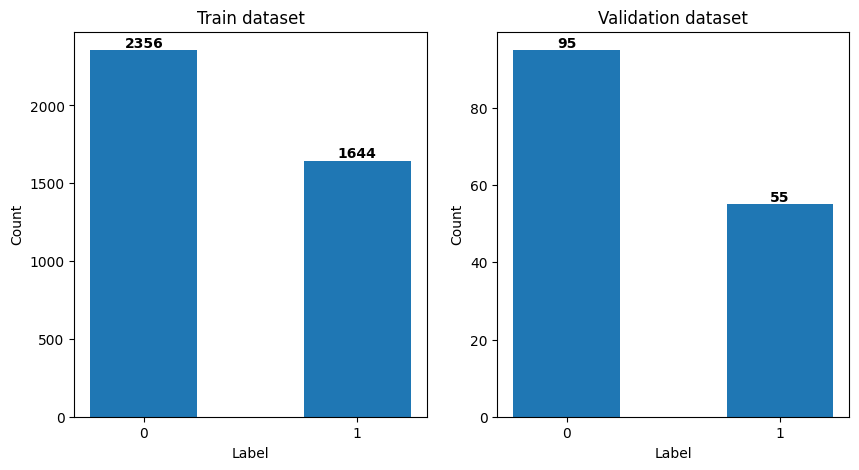

In [ ]:
import matplotlib.pyplot as plt

# check the balance of the label for train and validation dataset
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot train label bar chat
train_labels = train_set['label'].value_counts()
for i, v in enumerate(train_labels.values):
    ax[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
ax[0].bar([0, 1], train_labels.values, width=0.5)
ax[0].set_title('Train dataset')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['0', '1'])
# plot validation label bar chat
val_labels = val_set['label'].value_counts()
for i, v in enumerate(val_labels.values):
    ax[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
ax[1].bar([0, 1], val_labels.values, width=0.5)
ax[1].set_title('Validation dataset')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Count')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['0', '1'])


# Model Architecture (25 pts)

### Model Building and Training

This problem involves analyzing images, so using a convolutional neural network (CNN) for machine learning is appropriate. I will experiment with different CNN architectures to build a model that predicts whether images contain cancer.

I will start with a simple CNN model and then iterate, adding more advanced layers and complex architectures to find the best-performing model.

The neural network layers I will use to build this model include:
- Convolution layer
- MaxPooling layer
- Fully Connected Linear layer
- ReLU layer
- BatchNorm layer
- Dropout layer

I have chosen an epoch count of 30 and a batch size of 256.







In [ ]:
# define customDataset object

class CancerDataset(Dataset):

    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Build version 1 model

The first model is relatively simple, with just two convolutional layers and a fully connected layer that includes linear, ReLU, BatchNorm1d, and Dropout layers. There are no MaxPooling layers in the convolutional layers.

This model will serve as a baseline to test how well it performs with a simpler and straightforward structure.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True))#,
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))#,
        self.fc=nn.Sequential(
                nn.Linear(64*96*96, 128),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(128),
                nn.Dropout(0.4),
                nn.Linear(128, num_classes))
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# version one transform
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=589824, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score,roc_auc_score
import torchvision.transforms as transforms

train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []
best_acc = 0.0
min_loss = np.Inf

# Load the dataset
train_dataset = CancerDataset(df_data=train_set, data_dir=path, transform=transform_train)
val_dataset = CancerDataset(df_data=val_set, data_dir=path, transform=transform_train)
test_dataset = CancerDataset(df_data=sub, data_dir=test_path, transform=transform_test)
print(f"batch_size: {batch_size}")
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0

    # Training
    model.train()
    print(train_loader)
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):

        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss and accuracy
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / len(train_loader):.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in (tqdm(val_loader, total=int(len(val_loader)))):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Loss and accuracy
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            y_actual = labels.data.cpu().numpy()
            y_pred = outputs[:,-1].detach().cpu().numpy()
            val_auc.append(roc_auc_score(y_actual, y_pred))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        #auc
        training_auc = np.mean(train_auc)
        validation_auc = np.mean(val_auc)
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 * correct / total}%')

batch_size: 256


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 0.5446


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/30], Validation Accuracy: 46.666666666666664%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/30], Training Loss: 0.4526


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/30], Validation Accuracy: 62.666666666666664%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/30], Training Loss: 0.4229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/30], Validation Accuracy: 62.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/30], Training Loss: 0.4040


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/30], Validation Accuracy: 79.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/30], Training Loss: 0.3850


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/30], Validation Accuracy: 63.333333333333336%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/30], Training Loss: 0.3537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/30], Validation Accuracy: 78.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/30], Training Loss: 0.3182


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/30], Training Loss: 0.2510


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/30], Validation Accuracy: 74.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/30], Training Loss: 0.1863


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/30], Validation Accuracy: 75.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/30], Training Loss: 0.1438


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/30], Validation Accuracy: 72.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/30], Training Loss: 0.0993


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/30], Training Loss: 0.0654


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/30], Validation Accuracy: 78.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/30], Training Loss: 0.0373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/30], Training Loss: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/30], Validation Accuracy: 74.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/30], Training Loss: 0.0285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/30], Training Loss: 0.0184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/30], Validation Accuracy: 77.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/30], Training Loss: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/30], Training Loss: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/30], Validation Accuracy: 76.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/30], Training Loss: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/30], Validation Accuracy: 75.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/30], Training Loss: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/30], Training Loss: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/30], Validation Accuracy: 79.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/30], Training Loss: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/30], Validation Accuracy: 69.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/30], Training Loss: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/30], Validation Accuracy: 78.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/30], Training Loss: 0.0029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/30], Validation Accuracy: 74.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/30], Training Loss: 0.0025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/30], Validation Accuracy: 74.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/30], Training Loss: 0.0024


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/30], Validation Accuracy: 72.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/30], Training Loss: 0.0015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/30], Validation Accuracy: 75.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/30], Training Loss: 0.0015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/30], Validation Accuracy: 74.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/30], Training Loss: 0.0020


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/30], Validation Accuracy: 77.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/30], Training Loss: 0.0017


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/30], Validation Accuracy: 77.33333333333333%


# Results and Analysis

Based on the accuracy rate plot below, both the training and validation accuracy are progressing relatively well. However, while the training accuracy is advancing towards 97%, the validation accuracy is stuck at around 85%. This discrepancy could be due to overfitting, as the model is learning the training data too well.

For the next version, I will try a more complex CNN architecture with additional regularization parameters. Since 30 epochs seem to work fine, it may not be necessary to train for more epochs.





first version of model


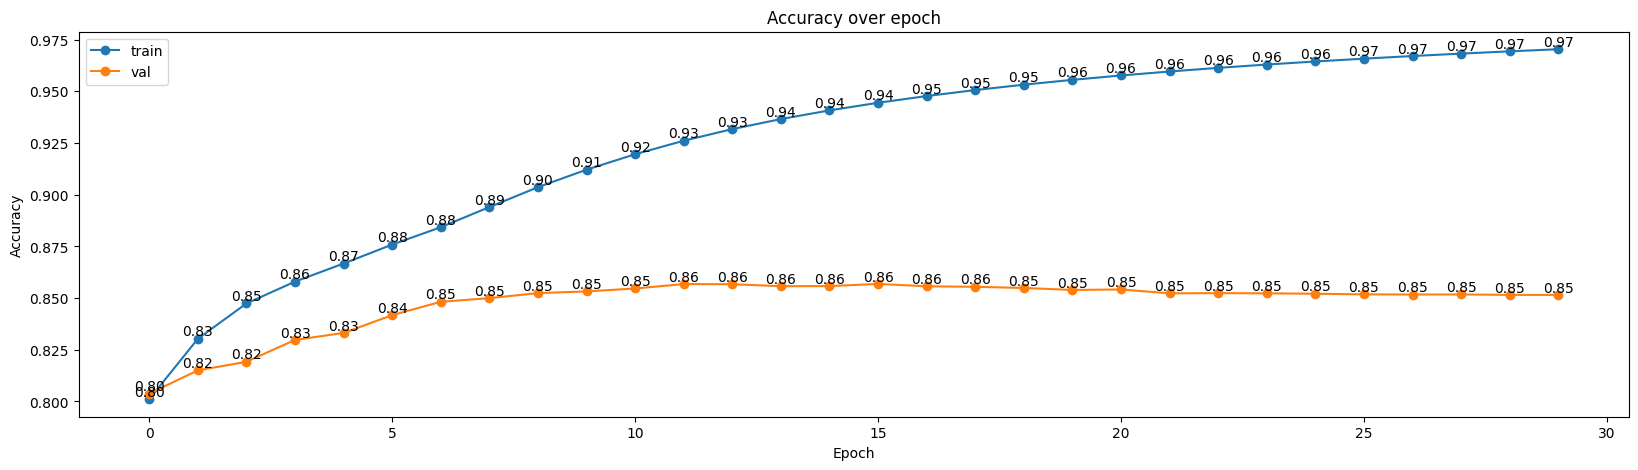

In [ ]:
print(f"first version of model")
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
# Adding value labels
for i, value in enumerate(train_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(val_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [ ]:
import pickle
# Save the lists to a file
with open('model_metrics1.pkl', 'wb') as f:
    pickle.dump([train_auc, val_auc, train_auc_epoch, val_auc_epoch], f)

In [ ]:
import pickle
with open('model_metrics1.pkl', 'rb') as f:
    train_auc, val_auc, train_auc_epoch, val_auc_epoch = pickle.load(f)

### Building version 2 model

Although the first version is not bad, there is definitely room for improvement. In Version 2, I will add more convolutional layers. Additionally, 2D MaxPooling layers will be added after each convolutional layer to help mitigate the overfitting issue.

In [ ]:
# version 2 CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.fc=nn.Sequential(
                nn.Linear(512*3*3, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, num_classes))

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# version two transform (same as version one)
# Define the transforms
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score,roc_auc_score
import torchvision.transforms as transforms

train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []
best_acc = 0.0
min_loss = np.Inf

# Load the dataset
train_dataset = CancerDataset(df_data=train_set, data_dir=path, transform=transform_train)
val_dataset = CancerDataset(df_data=val_set, data_dir=path, transform=transform_train)
test_dataset = CancerDataset(df_data=sub, data_dir=test_path, transform=transform_test)
print(f"batch_size: {batch_size}")
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0

    # Training
    model.train()
    print(train_loader)
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss and accuracy
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / len(train_loader):.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in (tqdm(val_loader, total=int(len(val_loader)))):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Loss and accuracy
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            y_actual = labels.data.cpu().numpy()
            y_pred = outputs[:,-1].detach().cpu().numpy()
            val_auc.append(roc_auc_score(y_actual, y_pred))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #auc
        training_auc = np.mean(train_auc)
        validation_auc = np.mean(val_auc)
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)
        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc
        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 * correct / total}%')

batch_size: 256


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 0.5474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/30], Validation Accuracy: 59.333333333333336%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/30], Training Loss: 0.4275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/30], Validation Accuracy: 68.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/30], Training Loss: 0.3944


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/30], Validation Accuracy: 79.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/30], Training Loss: 0.3849


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/30], Validation Accuracy: 79.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/30], Training Loss: 0.3750


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/30], Validation Accuracy: 77.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/30], Training Loss: 0.3666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/30], Training Loss: 0.3482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/30], Training Loss: 0.3244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/30], Validation Accuracy: 73.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/30], Training Loss: 0.3291


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/30], Validation Accuracy: 73.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/30], Training Loss: 0.3157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/30], Training Loss: 0.2804


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/30], Training Loss: 0.2741


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/30], Training Loss: 0.2491


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/30], Validation Accuracy: 81.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/30], Training Loss: 0.2188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/30], Training Loss: 0.1613


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/30], Validation Accuracy: 88.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/30], Training Loss: 0.1367


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/30], Training Loss: 0.0829


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/30], Training Loss: 0.0795


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/30], Training Loss: 0.0438


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/30], Validation Accuracy: 82.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/30], Training Loss: 0.0376


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/30], Validation Accuracy: 77.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/30], Training Loss: 0.0232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/30], Validation Accuracy: 82.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/30], Training Loss: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/30], Validation Accuracy: 78.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/30], Training Loss: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/30], Validation Accuracy: 84.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/30], Training Loss: 0.0034


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/30], Validation Accuracy: 84.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/30], Training Loss: 0.0013


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/30], Validation Accuracy: 84.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/30], Training Loss: 0.0010


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/30], Validation Accuracy: 82.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/30], Training Loss: 0.0007


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/30], Validation Accuracy: 85.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/30], Training Loss: 0.0005


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/30], Validation Accuracy: 84.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/30], Training Loss: 0.0004


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/30], Validation Accuracy: 83.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/30], Training Loss: 0.0003


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/30], Validation Accuracy: 84.66666666666667%


# Results and Analysis

The Version 2 model performs better than Version 1. The training set accuracy reaches about 96%, while the validation accuracy remains around 89%, showing a slight improvement over Version 1. The advanced CNN model has further improved the training accuracy, but the improvement in validation accuracy is limited.  The overfitting issue is certainly addressed.

It is unclear if further increasing the complexity of the CNN architecture will help. For the next version, I will focus on more data augmentation to create a greater variety of images to see if the model can learn better.

Additionally, it may be possible to optimize the learning rate by increasing it slightly. This could speed up the learning process without compromising the quality of the machine learning.

Second version of model


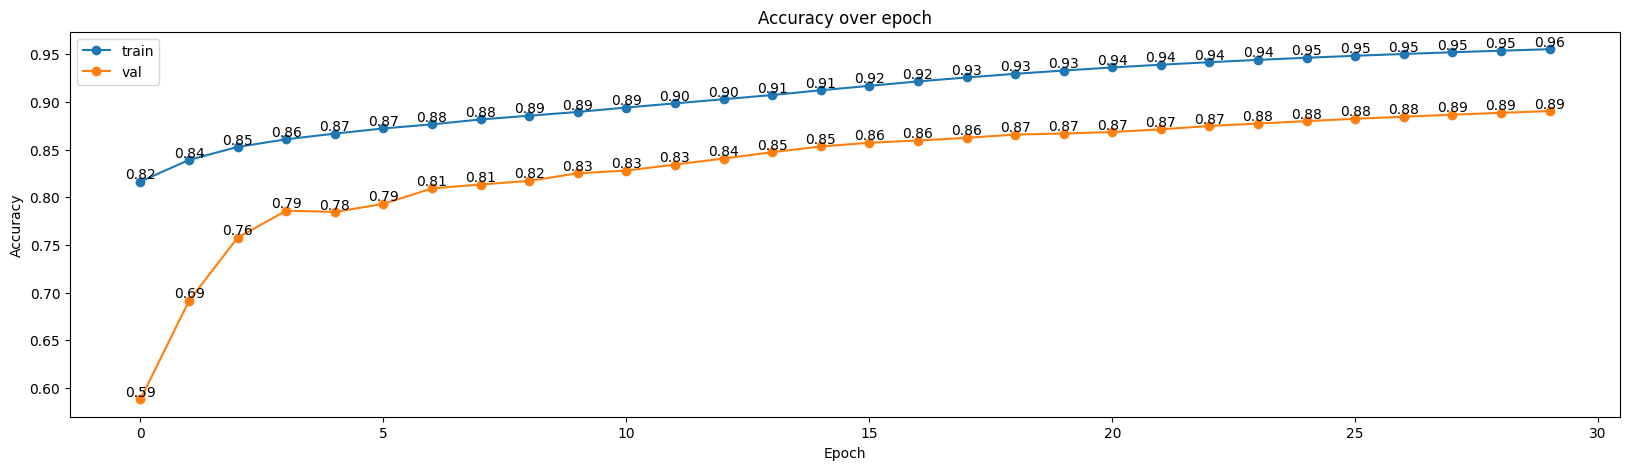

In [ ]:
print(f"Second version of model")
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
# Adding value labels
for i, value in enumerate(train_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(val_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [ ]:
import pickle
# Save the lists to a file
with open('model_metrics2.pkl', 'wb') as f:
    pickle.dump([train_auc, val_auc, train_auc_epoch, val_auc_epoch], f)

In [ ]:
import pickle
with open('model_metrics2.pkl', 'rb') as f:
    train_auc, val_auc, train_auc_epoch, val_auc_epoch = pickle.load(f)

## Building version 3 model

In this version, I am introducing more complex data augmentation by adding random flipping and rotation to the training data. I will incorporate RandomHorizontalFlip, RandomVerticalFlip, and RandomRotation to generate more variety from the existing images. This augmentation could help the model better learn the differentiation between positive and negative cases.

Additionally, the learning rate is increased to 0.01 to try to speed up the learning process.

In [ ]:
# Version 3 CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.fc=nn.Sequential(
                nn.Linear(512*3*3, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, num_classes))

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# Version 3
transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
# version 3 - learning rate set to 0.01

learning_rate = 0.01
train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []
best_acc = 0.0
min_loss = np.Inf

# Load the dataset
train_dataset = CancerDataset(df_data=train_set, data_dir=path, transform=transform_train)
val_dataset = CancerDataset(df_data=val_set, data_dir=path, transform=transform_train)
test_dataset = CancerDataset(df_data=sub, data_dir=test_path, transform=transform_test)
print(f"batch_size: {batch_size}")
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0

    # Training
    model.train()
    print(train_loader)
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss and accuracy
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / len(train_loader):.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in (tqdm(val_loader, total=int(len(val_loader)))):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Loss and accuracy
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            y_actual = labels.data.cpu().numpy()
            y_pred = outputs[:,-1].detach().cpu().numpy()
            val_auc.append(roc_auc_score(y_actual, y_pred))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #auc
        training_auc = np.mean(train_auc)
        validation_auc = np.mean(val_auc)
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)
        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc
        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {100 * correct / total}%')

batch_size: 256


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/30], Training Loss: 0.6825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/30], Validation Accuracy: 64.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/30], Training Loss: 0.5117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/30], Validation Accuracy: 69.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/30], Training Loss: 0.4787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/30], Validation Accuracy: 74.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/30], Training Loss: 0.4518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/30], Validation Accuracy: 76.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/30], Training Loss: 0.4434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/30], Validation Accuracy: 76.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/30], Training Loss: 0.4217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/30], Validation Accuracy: 78.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/30], Training Loss: 0.4189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/30], Validation Accuracy: 86.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/30], Training Loss: 0.4086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/30], Training Loss: 0.4078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/30], Training Loss: 0.4019


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/30], Validation Accuracy: 84.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/30], Training Loss: 0.3939


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/30], Training Loss: 0.3799


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/30], Validation Accuracy: 78.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/30], Training Loss: 0.3812


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/30], Validation Accuracy: 80.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/30], Training Loss: 0.3776


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/30], Training Loss: 0.3752


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/30], Validation Accuracy: 74.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/30], Training Loss: 0.3651


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/30], Validation Accuracy: 84.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/30], Training Loss: 0.3583


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/30], Training Loss: 0.3597


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/30], Training Loss: 0.3526


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/30], Validation Accuracy: 82.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/30], Training Loss: 0.3551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/30], Training Loss: 0.3604


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/30], Validation Accuracy: 79.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/30], Training Loss: 0.3422


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/30], Validation Accuracy: 86.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/30], Training Loss: 0.3321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/30], Validation Accuracy: 81.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/30], Training Loss: 0.3454


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/30], Validation Accuracy: 83.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/30], Training Loss: 0.3492


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/30], Validation Accuracy: 82.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/30], Training Loss: 0.3465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/30], Validation Accuracy: 82.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/30], Training Loss: 0.3406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/30], Validation Accuracy: 86.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/30], Training Loss: 0.3225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/30], Validation Accuracy: 85.33333333333333%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/30], Training Loss: 0.3319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/30], Validation Accuracy: 80.66666666666667%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/30], Training Loss: 0.3208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/30], Validation Accuracy: 80.0%


# Results and Analysis

In Version 3, the accuracy for both the training and validation sets improves consistently. The discrepancy between them is maintained at just 1%, so it is safe to assume overfitting is not an issue.

However, the overall validation accuracy did not improve from the previous version. To potentially enhance model performance, a more complex CNN architecture may be needed.

Third version of model


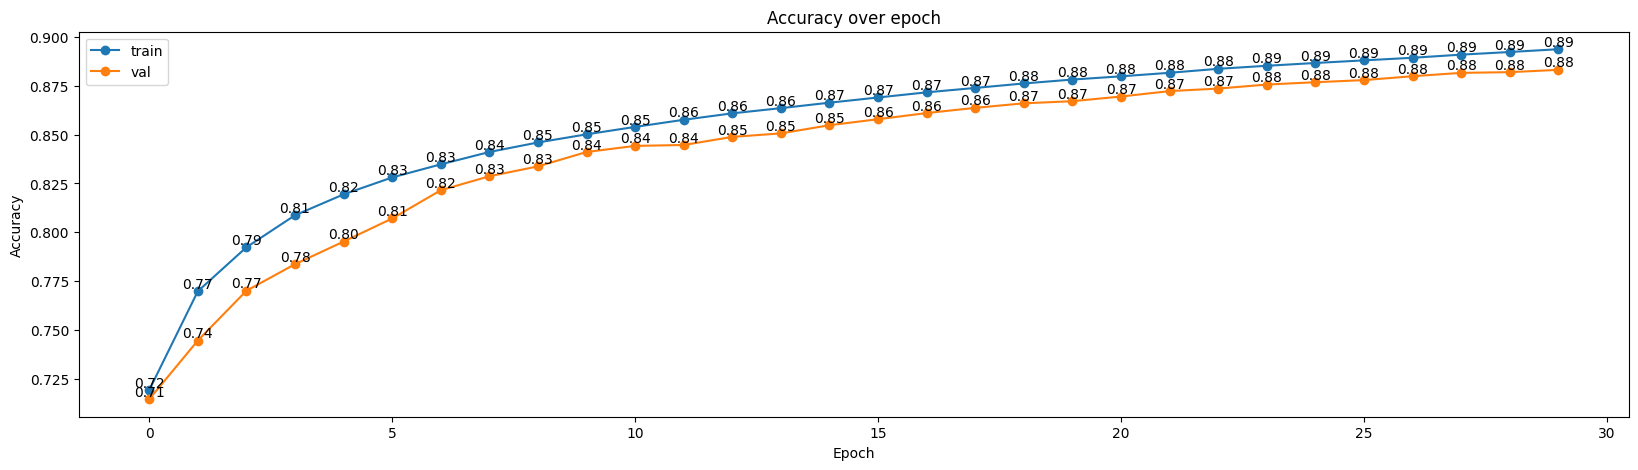

In [ ]:
print(f"Third version of model")
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
# Adding value labels
for i, value in enumerate(train_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

for i, value in enumerate(val_auc_epoch):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [ ]:
import pickle
# Save the lists to a file
with open('model_metrics3.pkl', 'wb') as f:
    pickle.dump([train_auc, val_auc, train_auc_epoch, val_auc_epoch], f)

In [ ]:
import pickle
with open('model_metrics3.pkl', 'rb') as f:
    train_auc, val_auc, train_auc_epoch, val_auc_epoch = pickle.load(f)

# Conclusion

The overall performance of the model is satisfactory, with accuracy reaching the 90% level. Overfitting was an issue in Version 1, but using a more complex CNN architecture with regularization layers has significantly reduced overfitting.

The accuracy has improved gradually and consistently, albeit slowly, in Version 3. While continuing to train for more epochs might yield slight improvements, it appears that the current network architecture has already captured most of the data patterns it can.

To further improve the model, I would try additional data augmentation and possibly add more CNN layers and fully connected layers. This could help the model capture more subtle and complex patterns that were previously missed.

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [ ]:
model.eval()

predictions = []

for i, (images, labels) in enumerate(tqdm(test_dataloader, total=int(len(test_dataloader)))):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    pred = outputs[:,1].detach().cpu().numpy()

    for j in pred:
        predictions.append(j)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
dir_main = '/content/drive/MyDrive/CuBoulder/DTSA5511DeepLearning/wk3/CancerData'
#path = dir_main + '/train/'
submission_file = dir_main + '/sample_submission.csv'
submission_df = pd.read_csv(submission_file)

sub['label'] = predictions
sub.loc[sub['label'] >= 0.5, 'label_zero_one'] = 1
sub.loc[sub['label'] < 0.5, 'label_zero_one'] = 0

# Merge the two DataFrames based on the 'id' column
merged_df = pd.merge(submission_df, sub, on='id', how='left')
# Update the 'label' column in the merged DataFrame
merged_df['label'] = merged_df['label_zero_one'].fillna(0.0)
merged_df['label'] = merged_df['label'].astype(int)
# Save the updated DataFrame back to the original submission_df
submission_df = merged_df[['id', 'label']]
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# save submission.csv to local storage
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

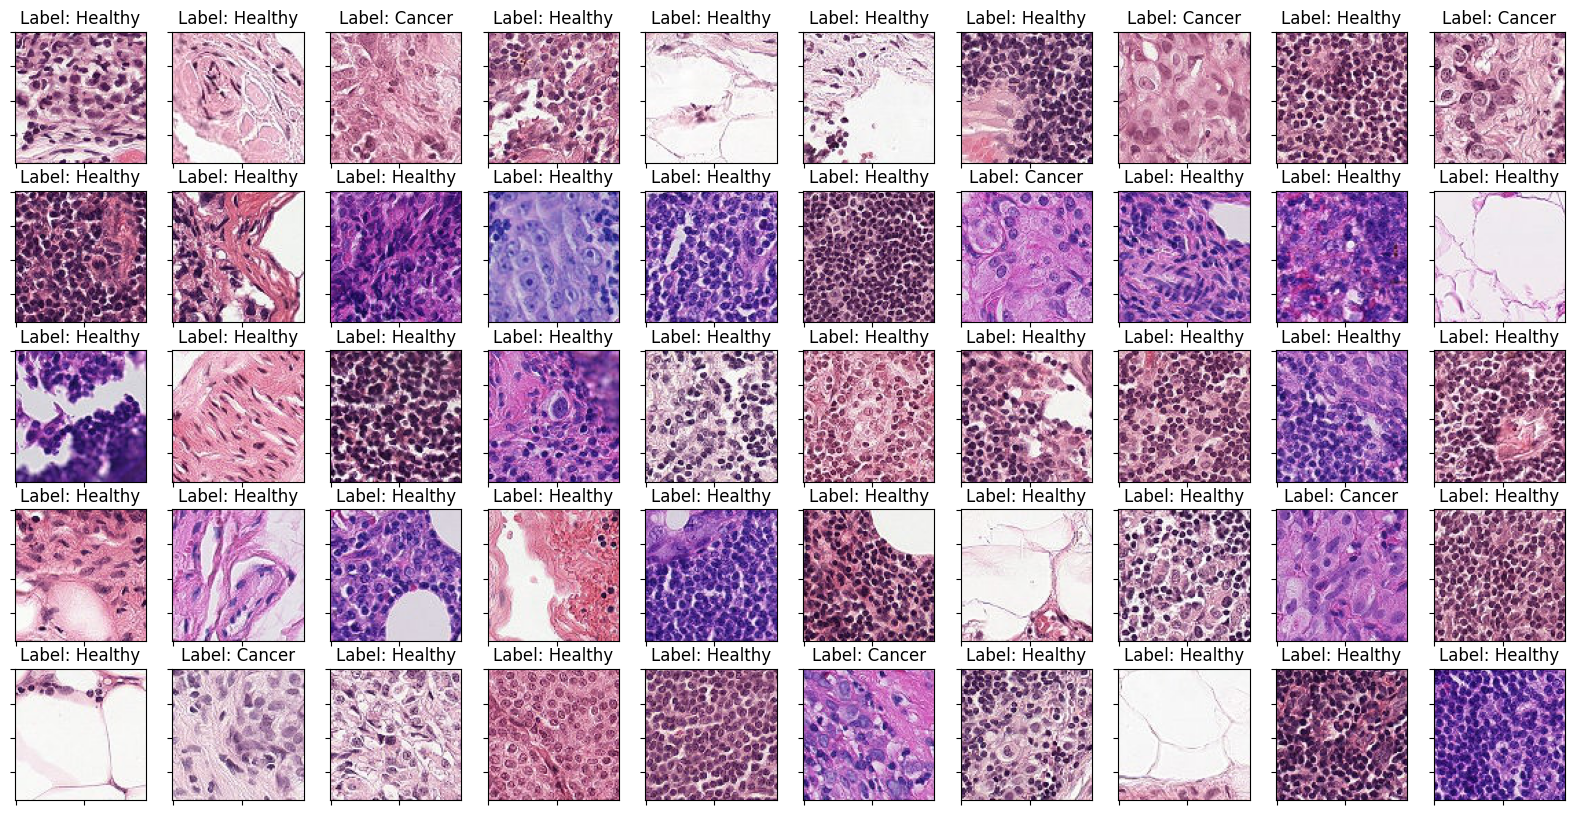

In [ ]:
test_images = np.random.choice(sub.id, size=50, replace=False)
#test_images = np.random.choice(sub.id, size=10, replace=False) #my change from 50 to 10

fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = test_images[m + n*10]
        image = plt.imread(test_path + img_id + ".tif")
        pred = sub.loc[sub['id'] == img_id, 'label_zero_one'].values[0]
        label = "Cancer" if(pred >= 0.5) else "Healthy"
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)
        ax[n,m].set_title("Label: " + label)